# Model Testing

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

## Hasil Training

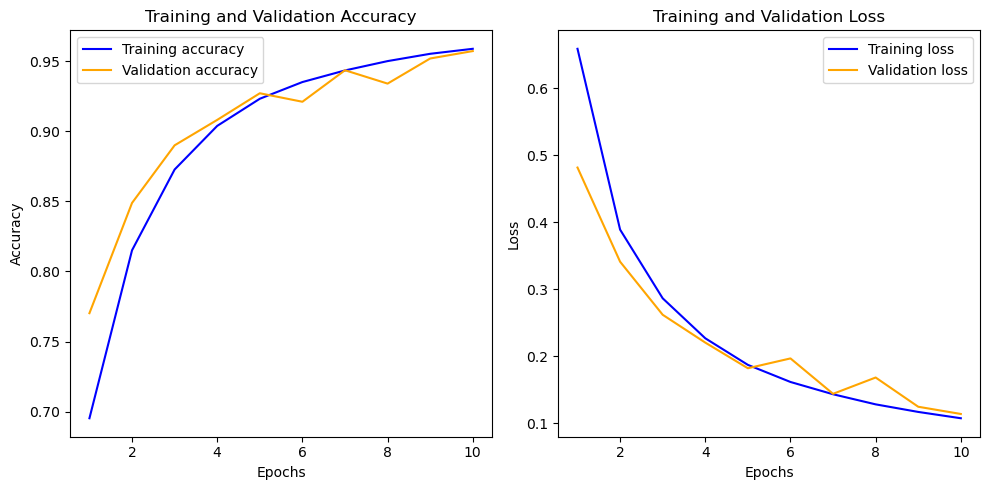

In [2]:
import json

# Muat data history dari file JSON
with open('EffNetV2B0_92/history.json', 'r') as f:
    history_dict = json.load(f)

# Ekstrak acc dan loss
acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy'] 
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss']

# Dapatkan jumlah epoch
epochs = range(1, len(acc_values) + 1)

# Buat subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot akurasi untuk data pelatihan dan validasi
ax[0].plot(epochs, acc_values, label='Training accuracy', color='blue') # Garis biru
ax[0].plot(epochs, val_acc_values, label='Validation accuracy', color='orange') # Garis oranye 
ax[0].set_title('Training and Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot Loss untuk data pelatihan dan validasi
ax[1].plot(epochs, loss_values, label='Training loss', color='blue') # Garis biru
ax[1].plot(epochs, val_loss_values, label='Validation loss', color='orange') # Garis Oranye 
ax[1].set_title('Training and Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout() 
plt.show()

## Evaluasi Model

In [4]:
# Memuat model yang telah disimpan
model = load_model('EffNetV2B0_92/model_pi_roy.h5')

# Menyiapkan generator untuk data uji dengan shuffle=False untuk konsistensi
testgen = ImageDataGenerator(rescale=1./255)
test_generator = testgen.flow_from_directory(
    'Dataset/Test',
    target_size=(200, 200), 
    batch_size=32,
    class_mode='binary',
    shuffle=False
)
print("Test Label:\n", test_generator.class_indices)

# Mengevaluasi model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Found 30905 images belonging to 2 classes.
Test Label:
 {'Fake': 0, 'Real': 1}
966/966 ━━━━━━━━━━━━━━━━━━━━ 99s 100ms/step - accuracy: 0.9655 - loss: 0.0911
Test Loss: 0.1933
Test Accuracy: 92.24%


In [5]:
# Mendapatkan semua prediksi untuk data uji
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

966/966 ━━━━━━━━━━━━━━━━━━━━ 99s 101ms/step


Confusion Matrix:
[[14938   554]
 [ 1845 13568]]


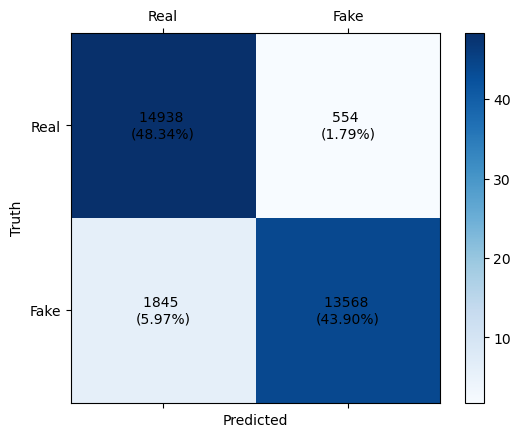


Classification Report:
              precision    recall  f1-score   support

        Fake       0.89      0.96      0.93     15492
        Real       0.96      0.88      0.92     15413

    accuracy                           0.92     30905
   macro avg       0.93      0.92      0.92     30905
weighted avg       0.93      0.92      0.92     30905



In [20]:
# Konversi prediksi ke kelas biner
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Mendapatkan label asli dari data uji
true_classes = test_generator.classes

# Menghitung confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Menghitung classification report
report = classification_report(true_classes, predicted_classes, target_names=['Fake', 'Real'])

# Menampilkan confusion matrix
print('Confusion Matrix:')
print(cm)

cm_percentage = cm / cm.sum() * 100
fig, ax = plt.subplots()
cax = ax.matshow(cm_percentage, cmap='Blues')
fig.colorbar(cax)

for i in range(2):
    for j in range(2):
        ax.text(j, i, f'{cm[i, j]} \n({cm_percentage[i, j]:.2f}%)', va='center', ha='center')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Real', 'Fake'])
ax.set_yticklabels(['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Menampilkan classification report
print('\nClassification Report:')
print(report)

## Visualisasi Hasil Deteksi

In [9]:
# Menyiapkan generator untuk data uji dengan shuffle=True untuk visualisasi
test_generator_vis = testgen.flow_from_directory(
    'Dataset/Test',
    target_size=(200, 200), 
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 30905 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


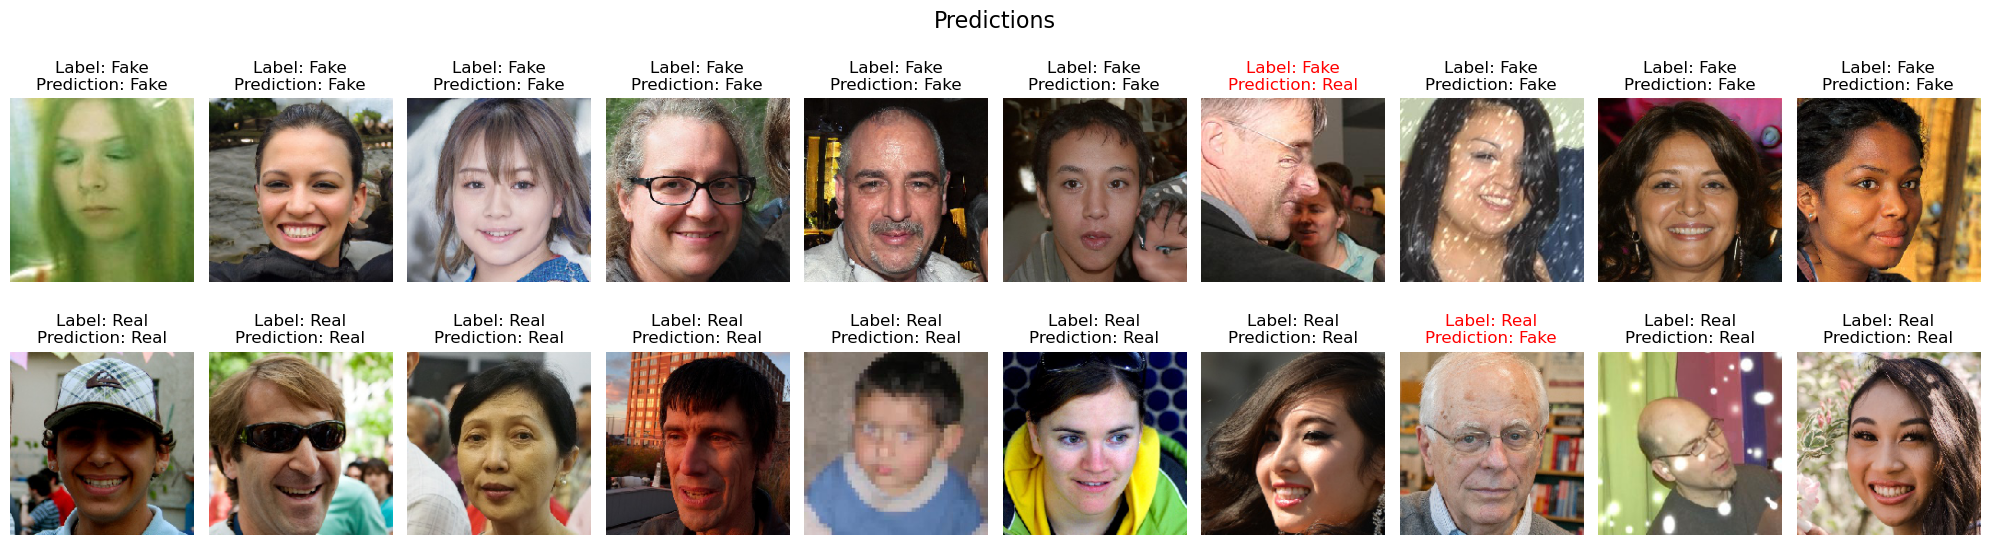

In [37]:
# Mengambil batch pertama dari test generator
test_images, test_labels = next(test_generator_vis)

# Mendapatkan prediksi untuk batch tersebut
predictions_vis = model.predict(test_images)

# Mengambil 10 gambar pertama dari masing-masing kelas untuk ditampilkan
fake_images = test_images[test_labels == 0][:10]
real_images = test_images[test_labels == 1][:10]

fake_predictions = predictions_vis[test_labels == 0][:10]
real_predictions = predictions_vis[test_labels == 1][:10]

# Menampilkan gambar
fig, axes = plt.subplots(2, 10, figsize=(20, 6))
fig.suptitle('Predictions', fontsize=16)

# Fungsi untuk menampilkan gambar dengan label dan prediksi
def plot_image(ax, image, label, prediction):
    ax.imshow(image)
    title = f"Real" if label == 1 else "Fake"
    pred_label = "Real" if prediction >= 0.5 else "Fake"
    color = 'red' if title != pred_label else 'black'
    ax.set_title(f"Label: {title}\nPrediction: {pred_label}", color=color)
    ax.axis('off')

# Menampilkan gambar Fake
for i in range(10):
    plot_image(axes[0, i], fake_images[i], 0, fake_predictions[i])

# Menampilkan gambar Real
for i in range(10):
    plot_image(axes[1, i], real_images[i], 1, real_predictions[i])

plt.tight_layout()
plt.show()